In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-12-08 09:34:28.722523: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 09:34:28.745446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 09:34:29.175360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Set random seeds untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Konfigurasi GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

W0000 00:00:1765186469.408153 1639094 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
class Config:
    DATA_PATH = '../data/'

    # Rasio split dataset
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15

    # Parameter
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    EPOCHS = 500

    # Class names
    CLASSES = ['glioblastoma', 'non-glioblastoma']
    NUM_CLASSES = len(CLASSES)

config = Config()

In [4]:
def load_data():
    data = []
    for class_name in config.CLASSES:
        class_path = os.path.join(config.DATA_PATH, class_name)
        files = glob.glob(os.path.join(class_path, '*.*'))

        for file in files:
            data.append({
                'filepath': file,
                'label': class_name
            })

    df = pd.DataFrame(data)
    train_df, test_val_df = train_test_split(
        df,
        test_size=1 - config.TRAIN_RATIO,
        stratify=df['label'],
        random_state=42
    )
    val_df, test_df = train_test_split(
        test_val_df,
        test_size=config.TEST_RATIO/(config.TEST_RATIO + config.VAL_RATIO),
        stratify=test_val_df['label'],
        random_state=42
    )

    train_df['split'] = 'train'
    val_df['split'] = 'val'
    test_df['split'] = 'test'

    return pd.concat([train_df, val_df, test_df])

In [5]:
def clahe(image):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)

    return enhanced

def denoise(image):
    denoised = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    return denoised

def skull_stripping(image):
    h, w = image.shape[:2]
    
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(binary, kernel, iterations=2)
    dilated = cv2.dilate(eroded, kernel, iterations=3)
    
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        dilated, connectivity=4, ltype=cv2.CV_32S
    )

    if num_labels > 1:

        areas = stats[1:, cv2.CC_STAT_AREA]
        largest_label = 1 + np.argmax(areas)
        brain_mask = (labels == largest_label).astype(np.uint8) * 255
        
        min_area = (h * w) * 0.01
        if stats[largest_label, cv2.CC_STAT_AREA] < min_area:
            brain_mask = dilated
    else:
        brain_mask = dilated
    
    result = cv2.bitwise_and(image, image, mask=brain_mask)
    
    return result

def intensity_normalization(image):
    i_min = np.min(image)
    i_max = np.max(image)
    
    if i_max - i_min > 0:
        normalized = ((image - i_min) / (i_max - i_min) * 255).astype(np.uint8)
    else:
        normalized = image.astype(np.uint8)
    
    return normalized

In [6]:
def create_data_generators(df, prepro):
    df['filepath'] = df['filepath'].astype(str)

    train_df = df[df['split'] == 'train']
    val_df = df[df['split'] == 'val']
    test_df = df[df['split'] == 'test']

    def preprocessing_wrapper(img):
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
        else:
            gray = img.astype(np.uint8)
        
        if prepro == "clahe":
            gray = clahe(gray)
        elif prepro == "denoise":
            gray = denoise(gray)
        elif prepro == "skull_stripping":
            gray = skull_stripping(gray)
        elif prepro == "intensity_normalization":
            gray = intensity_normalization(gray)

        img_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        return img_rgb.astype(np.float32)

    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        preprocessing_function=preprocessing_wrapper if prepro != "base" else None
    )
    val_test_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_wrapper if prepro != "base" else None
    )

    # Generator untuk masing-masing set
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='label',
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    val_generator = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='filepath',
        y_col='label',
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    test_generator = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='filepath',
        y_col='label',
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [7]:
def build_model(input_shape=(224,224,3), num_classes=config.NUM_CLASSES):
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [8]:
def compile_and_train_model(model, train_generator, val_generator, epochs=500):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    # Train model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Dapatkan epoch terbaik dari early stopping
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
    if best_epoch < 0:
        best_epoch = len(history.history['val_loss']) - 1

    print(f"\nTraining stopped at epoch {early_stopping.stopped_epoch + 1}")
    print(f"Best model at epoch {best_epoch + 1}")

    return model, history, best_epoch

In [9]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Gradient of the output neuron with regard to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel by "how important this channel is"
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def apply_gradcam_overlay(img, heatmap, alpha=0.4, threshold=0.5):
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Apply threshold to focus on important regions
    heatmap_thresholded = np.where(heatmap >= threshold, heatmap, 0)
    
    # Rescale to 0-1 after thresholding for better contrast
    if heatmap_thresholded.max() > 0:
        heatmap_thresholded = (heatmap_thresholded - heatmap_thresholded.min()) / \
                              (heatmap_thresholded.max() - heatmap_thresholded.min())
    
    # Convert heatmap to RGB
    heatmap_colored = np.uint8(255 * heatmap_thresholded)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    
    # Create mask for transparent areas (below threshold)
    mask = (heatmap >= threshold).astype(np.float32)
    mask = np.stack([mask] * 3, axis=-1)
    
    # Superimpose the heatmap on original image only where mask is active
    superimposed_img = heatmap_colored * alpha * mask + img * (1 - alpha * mask)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    return superimposed_img

def visualize_gradcam_preprocessing(df, model, prepro="base", threshold=0.5):
    # Get last conv layer name from EfficientNetB0
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        # Check if layer has output shape with 4 dimensions (batch, height, width, channels)
        if len(layer.output.shape) == 4:
            last_conv_layer_name = layer.name
            break
    
    if last_conv_layer_name is None:
        print("Could not find convolutional layer in model")
        return
    
    print(f"Using layer '{last_conv_layer_name}' for Grad-CAM")
    print(f"Activation threshold: {threshold} (Red/Yellow = High importance)")
    
    # Select 2 samples per class
    samples = []
    for class_name in config.CLASSES:
        class_samples = df[df['label'] == class_name].head(2)
        samples.extend([(path, label) for path, label in zip(
            class_samples['filepath'].tolist(),
            class_samples['label'].tolist()
        )])
    
    # Create layout: 2 rows (one per class), 4 columns (img, pred, img, pred)
    fig, axes = plt.subplots(len(config.CLASSES), 4, figsize=(20, 5*len(config.CLASSES)))
    
    # Handle case when only one class
    if len(config.CLASSES) == 1:
        axes = axes.reshape(1, -1)
    
    sample_idx = 0
    for class_idx, class_name in enumerate(config.CLASSES):
        for col_pair in range(2):
            if sample_idx >= len(samples):
                break
                
            image_path, label = samples[sample_idx]
            original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Apply preprocessing
            if prepro == "clahe":
                processed = clahe(original)
            elif prepro == "denoise":
                processed = denoise(original)
            elif prepro == "skull_stripping":
                processed = skull_stripping(original)
            elif prepro == "intensity_normalization":
                processed = intensity_normalization(original)
            else:
                processed = original
            
            # Resize and convert to RGB
            img_resized = cv2.resize(processed, config.IMG_SIZE, interpolation=cv2.INTER_AREA)
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            
            # Prepare for model prediction
            img_array = np.expand_dims(img_rgb, axis=0).astype(np.float32)
            
            # Get prediction
            preds = model.predict(img_array, verbose=0)
            pred_class_idx = np.argmax(preds[0])
            pred_class_name = config.CLASSES[pred_class_idx]
            confidence = preds[0][pred_class_idx] * 100
            
            # Generate Grad-CAM heatmap
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class_idx)
            
            img_col = col_pair * 2
            pred_col = col_pair * 2 + 1
            
            # Image column: Grad-CAM Overlay
            gradcam_overlay = apply_gradcam_overlay(img_rgb, heatmap, alpha=0.5, threshold=threshold)
            axes[class_idx, img_col].imshow(gradcam_overlay)
            axes[class_idx, img_col].set_title(f'{label}\nSample {col_pair+1}', 
                                               fontsize=11, fontweight='bold')
            axes[class_idx, img_col].axis('off')
            
            # Prediction column: Prediction info
            is_correct = (label == pred_class_name)
            box_color = 'lightgreen' if is_correct else 'lightcoral'
            
            axes[class_idx, pred_col].text(0.5, 0.5, 
                                          f'True:\n{label}\n\n' + 
                                          f'Pred:\n{pred_class_name}\n\n' + 
                                          f'Conf:\n{confidence:.1f}%\n\n' + 
                                          f'{"✓" if is_correct else "✗"}',
                                          ha='center', va='center', fontsize=12, 
                                          bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.8, pad=0.8))
            axes[class_idx, pred_col].axis('off')
            axes[class_idx, pred_col].set_title('Prediction', fontsize=11, fontweight='bold')
            
            sample_idx += 1
    
    # Add main title
    fig.suptitle(f'Grad-CAM Visualization - {prepro.upper()} (Threshold: {threshold})', 
                 fontsize=15, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()

In [10]:
def visualize_preprocessing(df):
    samples = []
    for class_name in config.CLASSES:
        class_samples = df[df['label'] == class_name].head(1)
        samples.extend(class_samples['filepath'].tolist())

    fig, axes = plt.subplots(len(samples), 6, figsize=(20, 4*len(samples)))

    for idx, image_path in enumerate(samples):
        # Original
        original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        axes[idx, 0].imshow(original, cmap='gray')
        axes[idx, 0].set_title('Original')
        axes[idx, 0].axis('off')

        # CLAHE
        clahe_img = clahe(original)
        axes[idx, 1].imshow(clahe_img, cmap='gray')
        axes[idx, 1].set_title('After CLAHE')
        axes[idx, 1].axis('off')

        # Denoised
        denoised = denoise(original)
        axes[idx, 2].imshow(denoised, cmap='gray')
        axes[idx, 2].set_title('After Denoise')
        axes[idx, 2].axis('off')

        # Skull stripped
        skull_stripped = skull_stripping(original)
        axes[idx, 3].imshow(skull_stripped, cmap='gray')
        axes[idx, 3].set_title('After Skull Strip')
        axes[idx, 3].axis('off')

        # Normalized
        normalized = intensity_normalization(original)
        axes[idx, 4].imshow(normalized, cmap='gray')
        axes[idx, 4].set_title('After Normalization')
        axes[idx, 4].axis('off')

        # Final (resized and RGB)
        final = cv2.resize(original, config.IMG_SIZE)
        final_rgb = cv2.cvtColor(final, cv2.COLOR_GRAY2RGB)
        axes[idx, 5].imshow(final_rgb)
        axes[idx, 5].set_title('Final (RGB)')
        axes[idx, 5].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
def plot_training_history(history, best_epoch):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

In [12]:
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=config.CLASSES))

    cm = confusion_matrix(y_true, y_pred)
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # ROC AUC
    if len(config.CLASSES) == 2:
        auc = roc_auc_score(y_true, predictions[:, 1])
        fpr, tpr, _ = roc_curve(y_true, predictions[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    print("\nHasil Evaluasi:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if len(config.CLASSES) == 2:
        print(f"AUC-ROC: {auc:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'auc': auc if len(config.CLASSES) == 2 else None
    }

In [13]:
df = load_data()

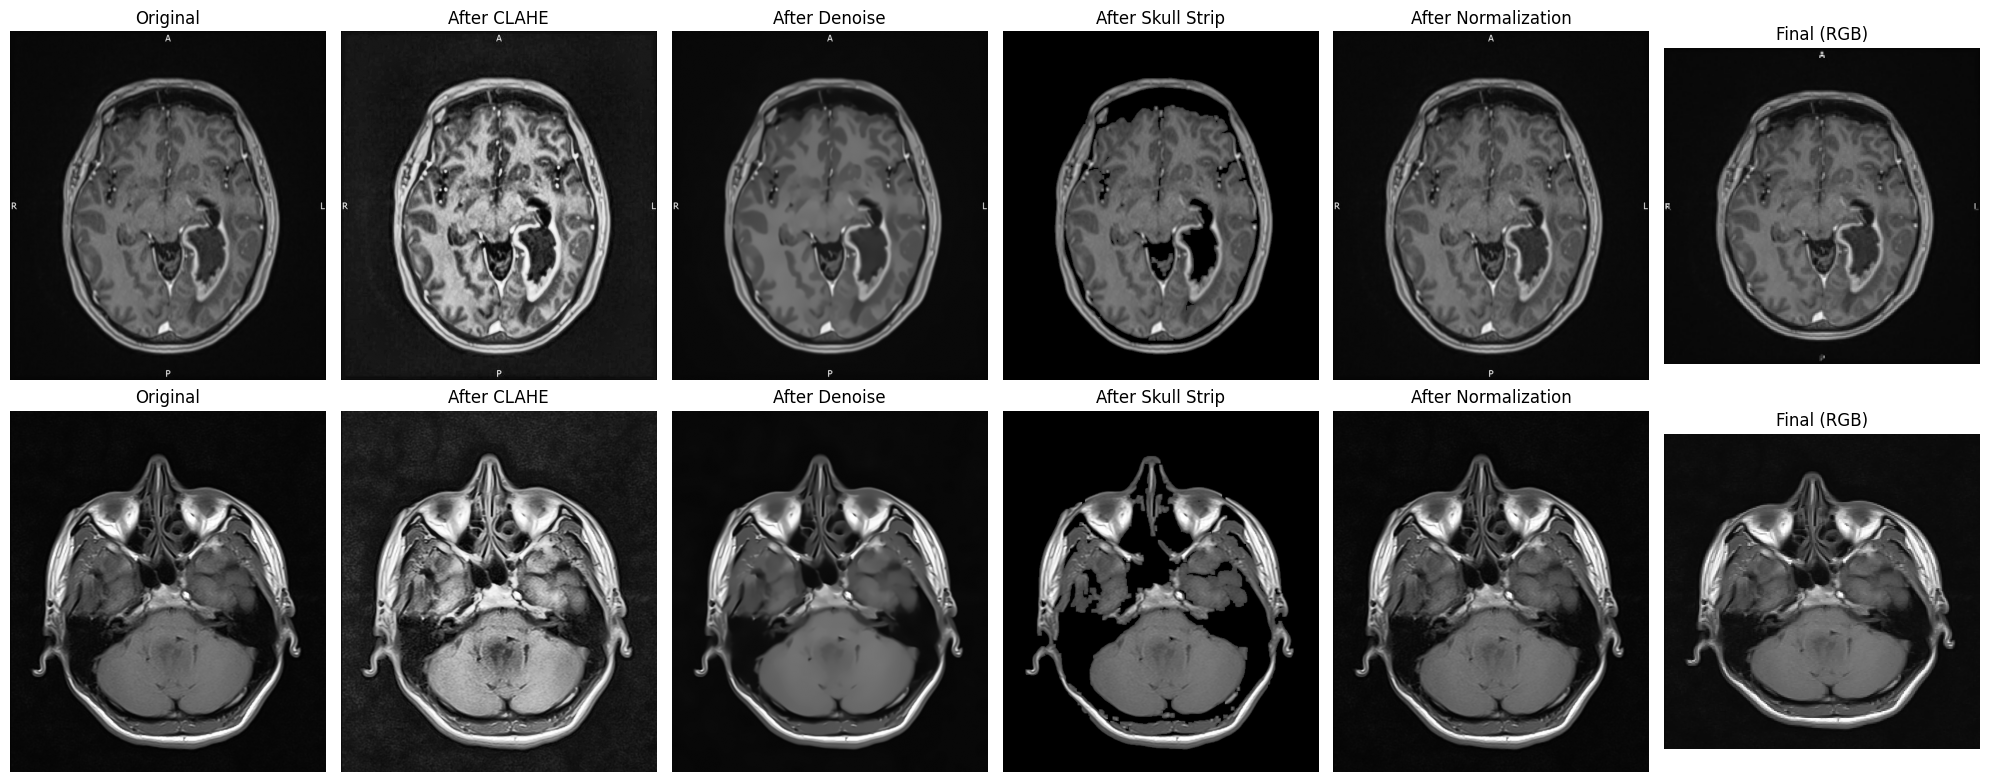

In [14]:
visualize_preprocessing(df)

In [15]:
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,410,661 (16.83 MB)

 Trainable params: 361,090 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Found 617 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.

Build model

Training model
Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.5705 - loss: 0.7112 - precision: 0.5705 - recall: 0.5705 - val_accuracy: 0.7727 - val_loss: 0.5169 - val_precision: 0.7727 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.7553 - loss: 0.5159 - precision: 0.7553 - recall: 0.7553 - val_accuracy: 0.7727 - val_loss: 0.4608 - val_precision: 0.7727 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.7666 - loss: 0.4628 - precision: 0.7666 - recall: 0.7666 - val_accuracy: 0.7727 - val_loss: 0.4313 - val_precision: 0.7727 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.7569 - 

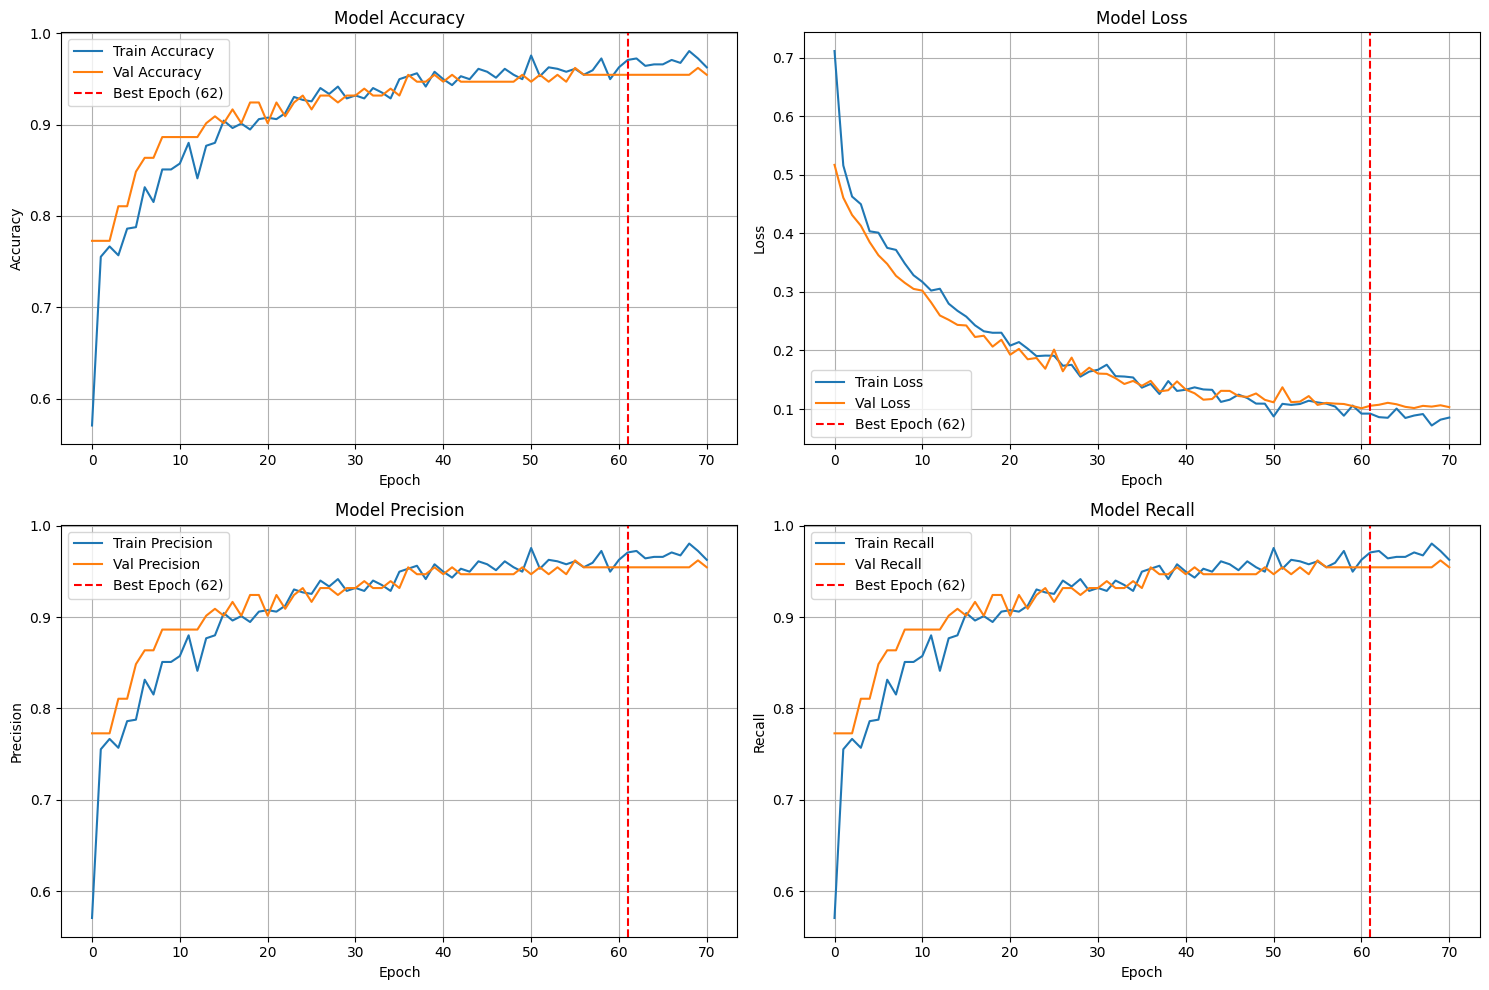


Evaluasi model
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step

Classification Report:
                  precision    recall  f1-score   support

    glioblastoma       0.83      0.97      0.90        31
non-glioblastoma       0.99      0.94      0.96       102

        accuracy                           0.95       133
       macro avg       0.91      0.95      0.93       133
    weighted avg       0.95      0.95      0.95       133



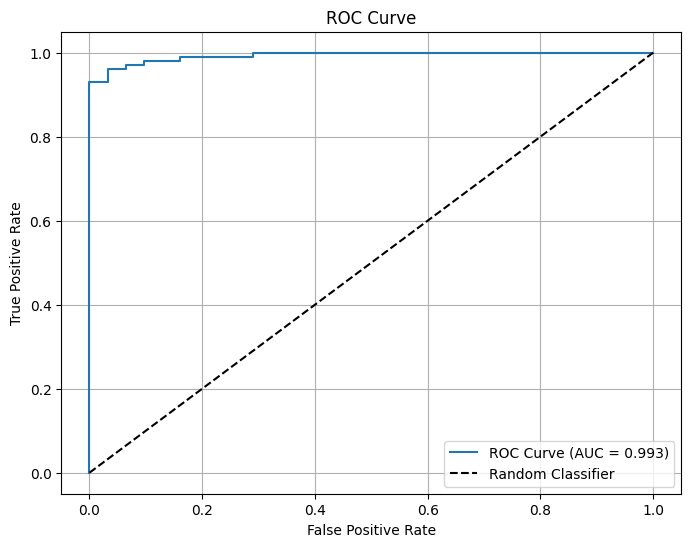


Hasil Evaluasi:
Accuracy: 0.9474
Precision: 0.9897
Recall: 0.9412
Specificity: 0.9677
F1-Score: 0.9648
AUC-ROC: 0.9930

Generating Grad-CAM visualizations...
Using layer 'top_activation' for Grad-CAM
Activation threshold: 0.5 (Red/Yellow = High importance)


/home/filkom/nada_tif/venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_244']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


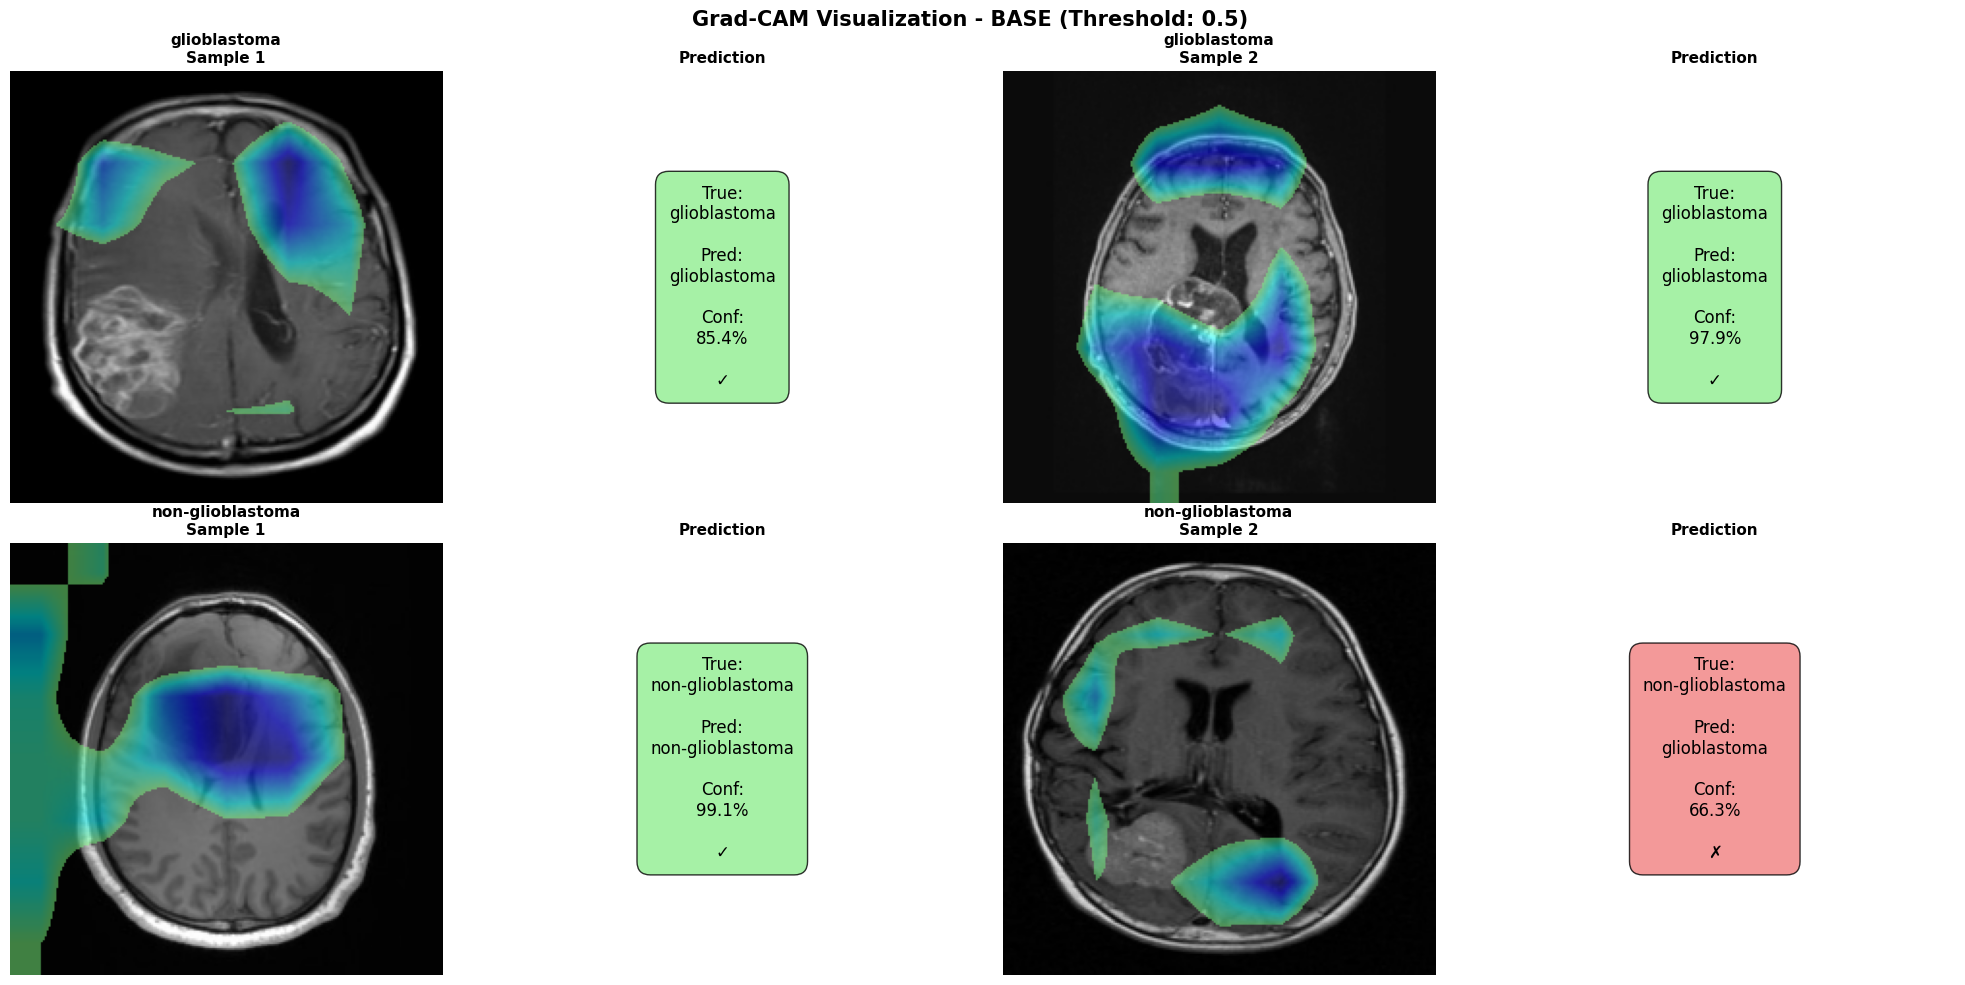

In [16]:
preprocess = "base"
train_generator, val_generator, test_generator = create_data_generators(df.copy(), preprocess)

print(f"\nBuild model")
model = build_model()

print(f"\nTraining model")
model, history, best_epoch = compile_and_train_model(
    model,
    train_generator,
    val_generator,
    epochs=config.EPOCHS
)

plot_training_history(history, best_epoch)

print("\nEvaluasi model")
metrics = evaluate_model(model, test_generator)

# Visualize Grad-CAM after training
print("\nGenerating Grad-CAM visualizations...")
visualize_gradcam_preprocessing(df[df['split'] == 'test'], model, preprocess, threshold=0.5)

model.save(f'{preprocess}.h5')

Found 617 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.

Build model

Training model
Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.7423 - loss: 0.5630 - precision: 0.7423 - recall: 0.7423 - val_accuracy: 0.7727 - val_loss: 0.4485 - val_precision: 0.7727 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.7828 - loss: 0.4691 - precision: 0.7828 - recall: 0.7828 - val_accuracy: 0.7955 - val_loss: 0.4065 - val_precision: 0.7955 - val_recall: 0.7955 - learning_rate: 1.0000e-04
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.7861 - loss: 0.4218 - precision: 0.7861 - recall: 0.7861 - val_accuracy: 0.8409 - val_loss: 0.3794 - val_precision: 0.8409 - val_recall: 0.8409 - learning_rate: 1.0000e-04
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.8152 - 

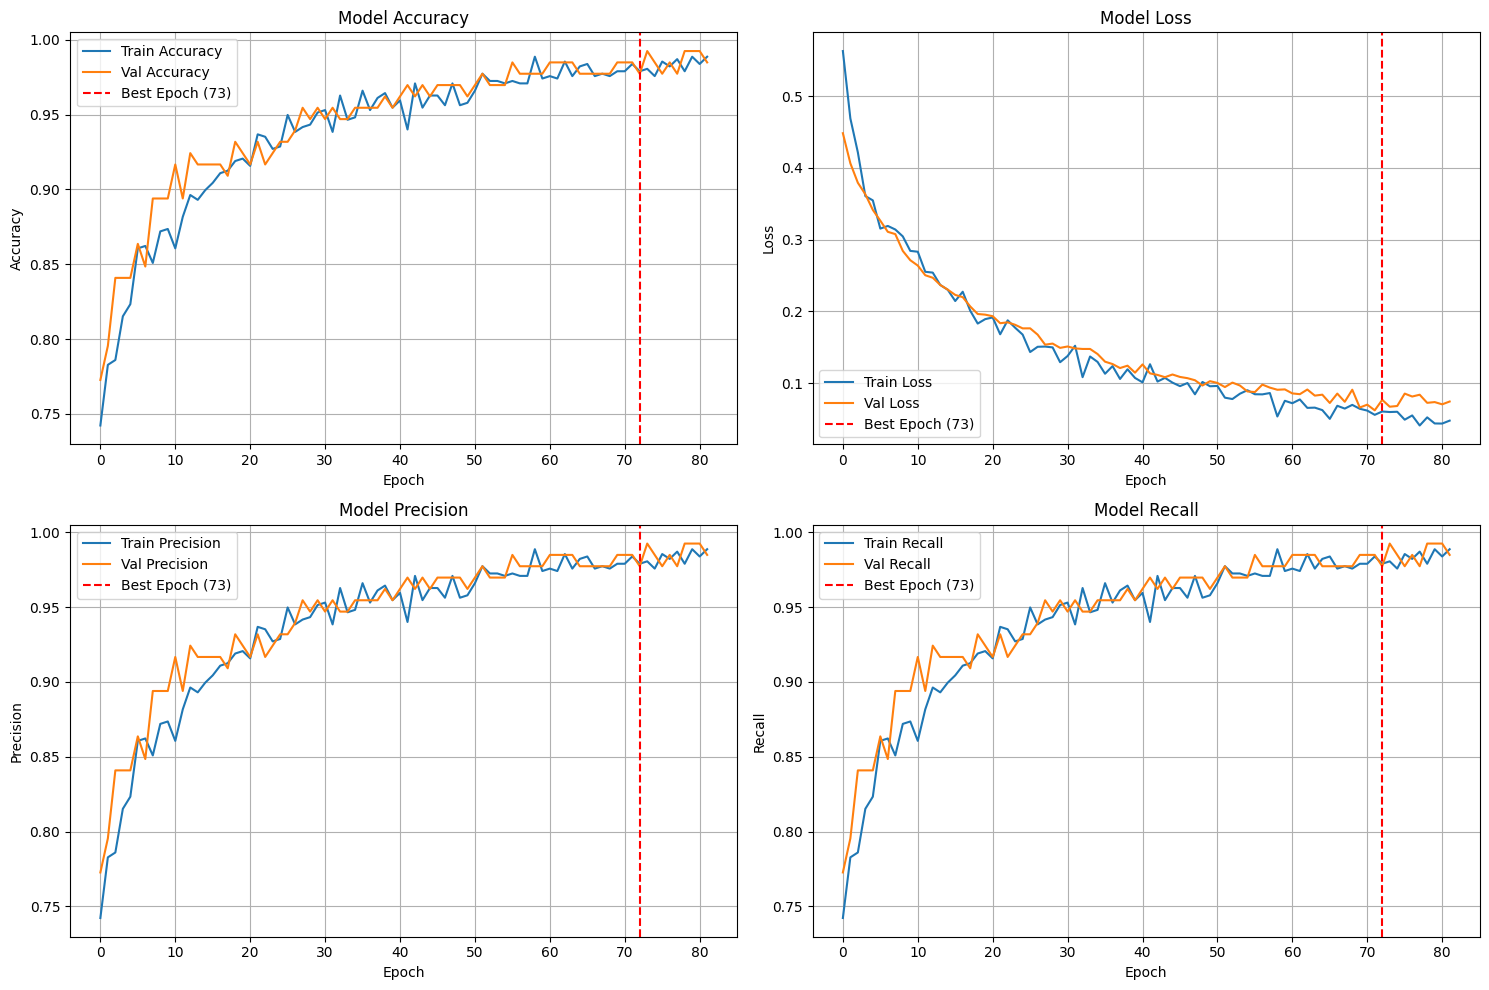


Evaluasi model
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/stepWARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7b6ee85f4860> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step

Classification Report:
                  precision    recall  f1-score   support

    glioblastoma       0.86      1.00      0.93        31
non-glioblastoma       1.00      0.95      0.97       102

        accuracy                           0.96       133
       macro avg       0.93      0.98      0.95       133
    weighted avg       0.97      0.96      0.96       133



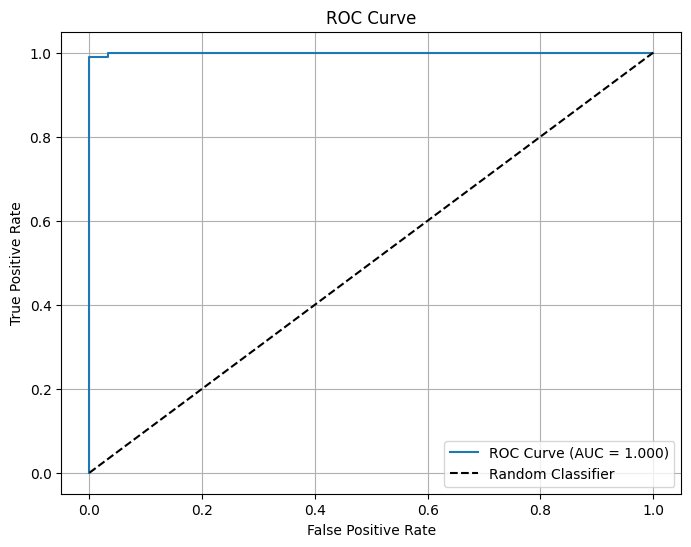


Hasil Evaluasi:
Accuracy: 0.9624
Precision: 1.0000
Recall: 0.9510
Specificity: 1.0000
F1-Score: 0.9749
AUC-ROC: 0.9997

Generating Grad-CAM visualizations...
Using layer 'top_activation' for Grad-CAM
Activation threshold: 0.5 (Red/Yellow = High importance)


/home/filkom/nada_tif/venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_494']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


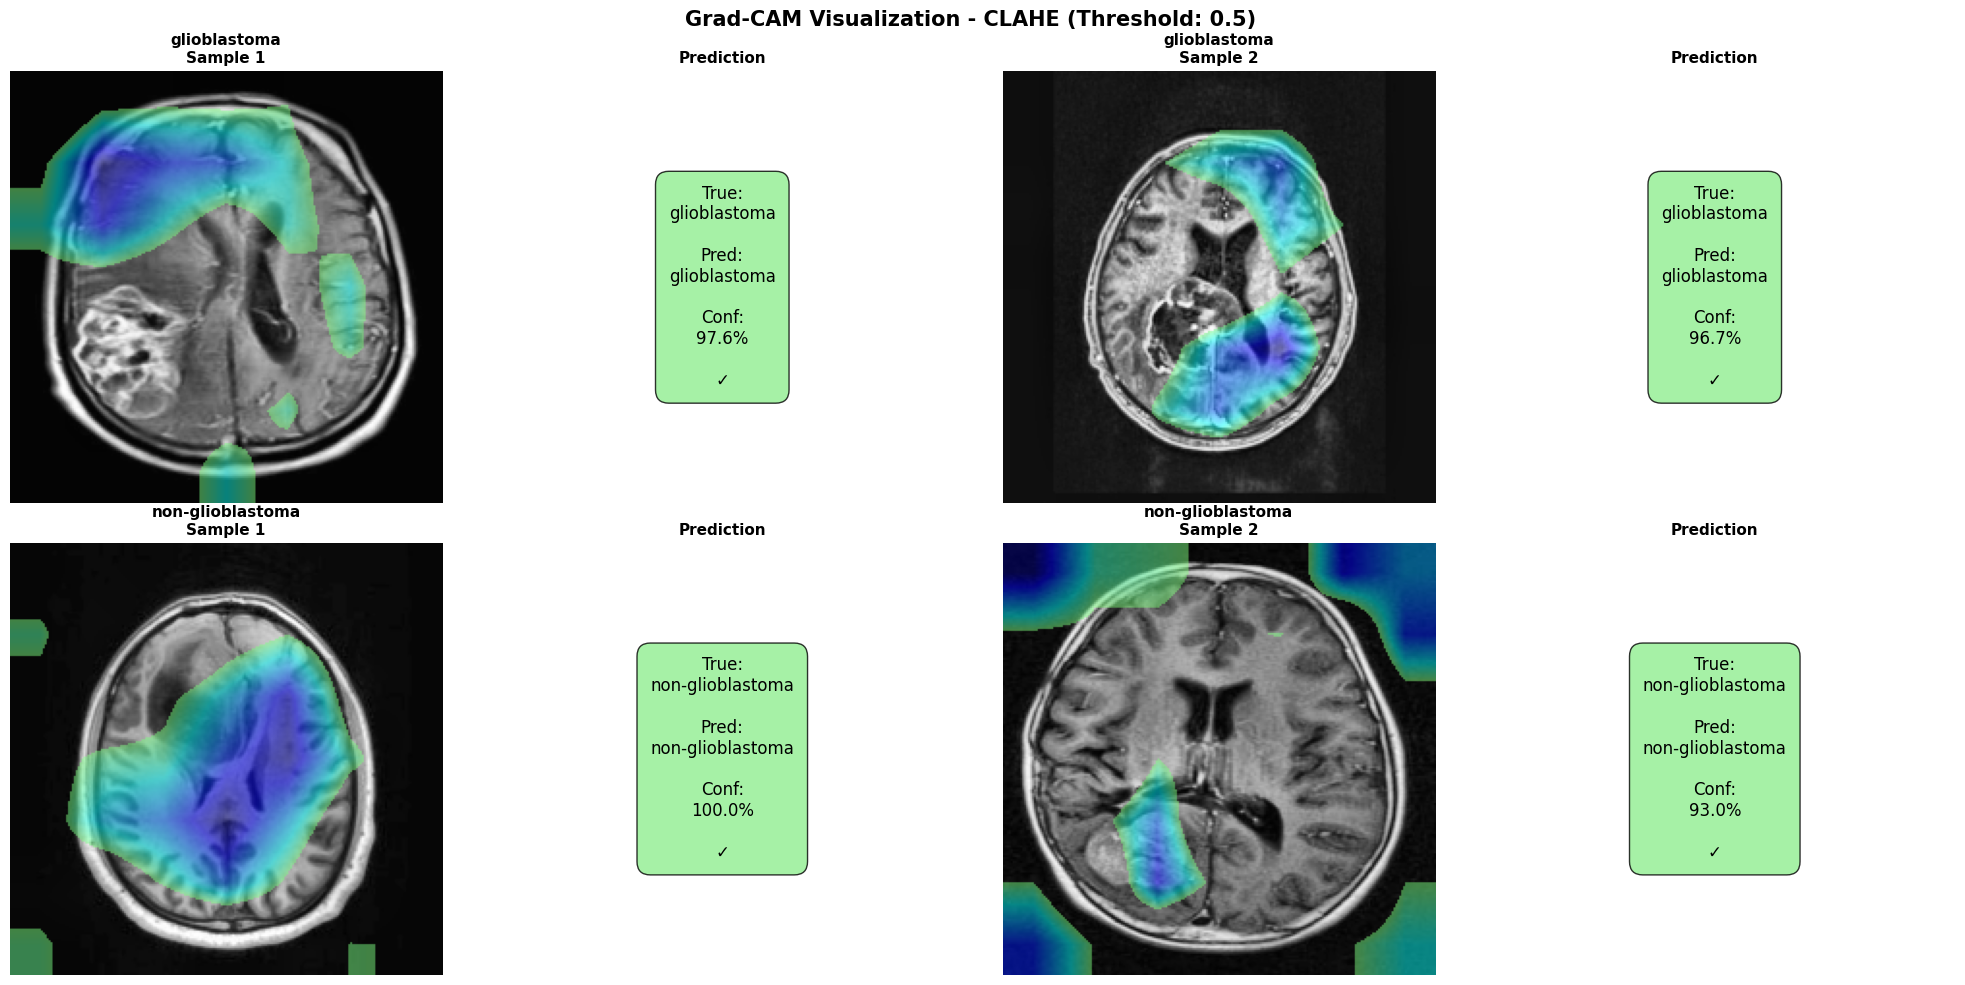

In [17]:
preprocess = "clahe"
train_generator, val_generator, test_generator = create_data_generators(df.copy(), preprocess)

print(f"\nBuild model")
model = build_model()

print(f"\nTraining model")
model, history, best_epoch = compile_and_train_model(
    model,
    train_generator,
    val_generator,
    epochs=config.EPOCHS
)

plot_training_history(history, best_epoch)

print("\nEvaluasi model")
metrics = evaluate_model(model, test_generator)

# Visualize Grad-CAM after training
print("\nGenerating Grad-CAM visualizations...")
visualize_gradcam_preprocessing(df[df['split'] == 'test'], model, preprocess, threshold=0.5)

model.save(f'{preprocess}.h5')

Found 617 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.

Build model

Training model
Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6256 - loss: 0.6426 - precision: 0.6256 - recall: 0.6256 - val_accuracy: 0.7727 - val_loss: 0.4645 - val_precision: 0.7727 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 952ms/step - accuracy: 0.7569 - loss: 0.4765 - precision: 0.7569 - recall: 0.7569 - val_accuracy: 0.7727 - val_loss: 0.4179 - val_precision: 0.7727 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 988ms/step - accuracy: 0.7763 - loss: 0.4334 - precision: 0.7763 - recall: 0.7763 - val_accuracy: 0.8030 - val_loss: 0.3837 - val_precision: 0.8030 - val_recall: 0.8030 - learning_rate: 1.0000e-04
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 953ms/step - accuracy: 0.7942 -

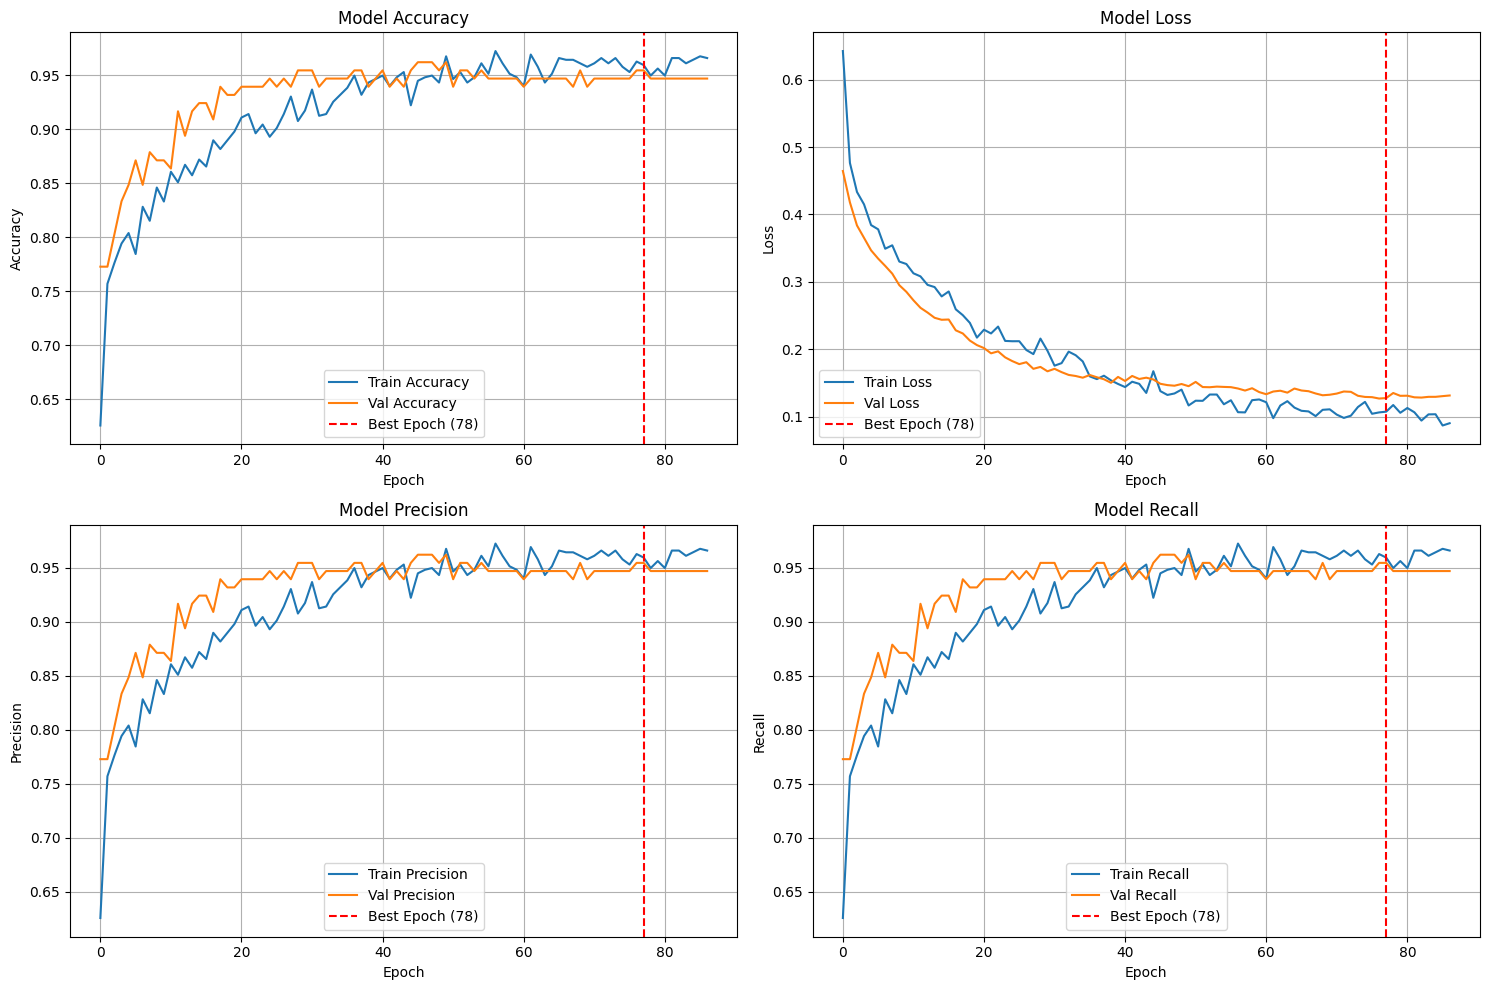


Evaluasi model
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 570ms/step

Classification Report:
                  precision    recall  f1-score   support

    glioblastoma       0.83      0.97      0.90        31
non-glioblastoma       0.99      0.94      0.96       102

        accuracy                           0.95       133
       macro avg       0.91      0.95      0.93       133
    weighted avg       0.95      0.95      0.95       133



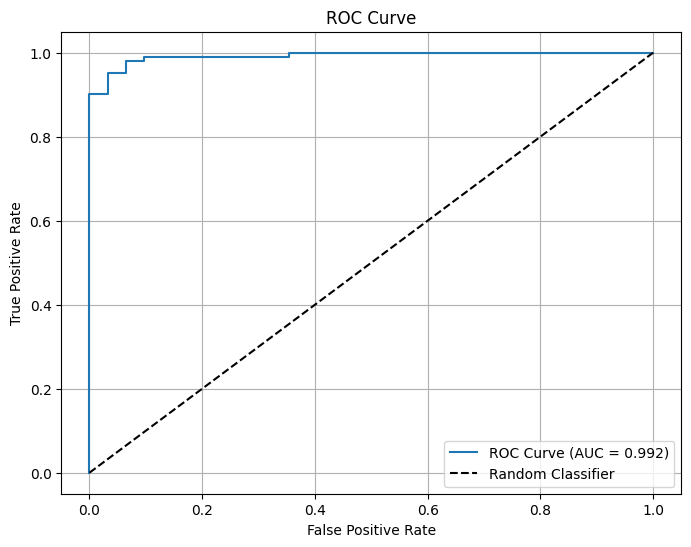


Hasil Evaluasi:
Accuracy: 0.9474
Precision: 0.9897
Recall: 0.9412
Specificity: 0.9677
F1-Score: 0.9648
AUC-ROC: 0.9921

Generating Grad-CAM visualizations...
Using layer 'top_activation' for Grad-CAM
Activation threshold: 0.5 (Red/Yellow = High importance)


/home/filkom/nada_tif/venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_744']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


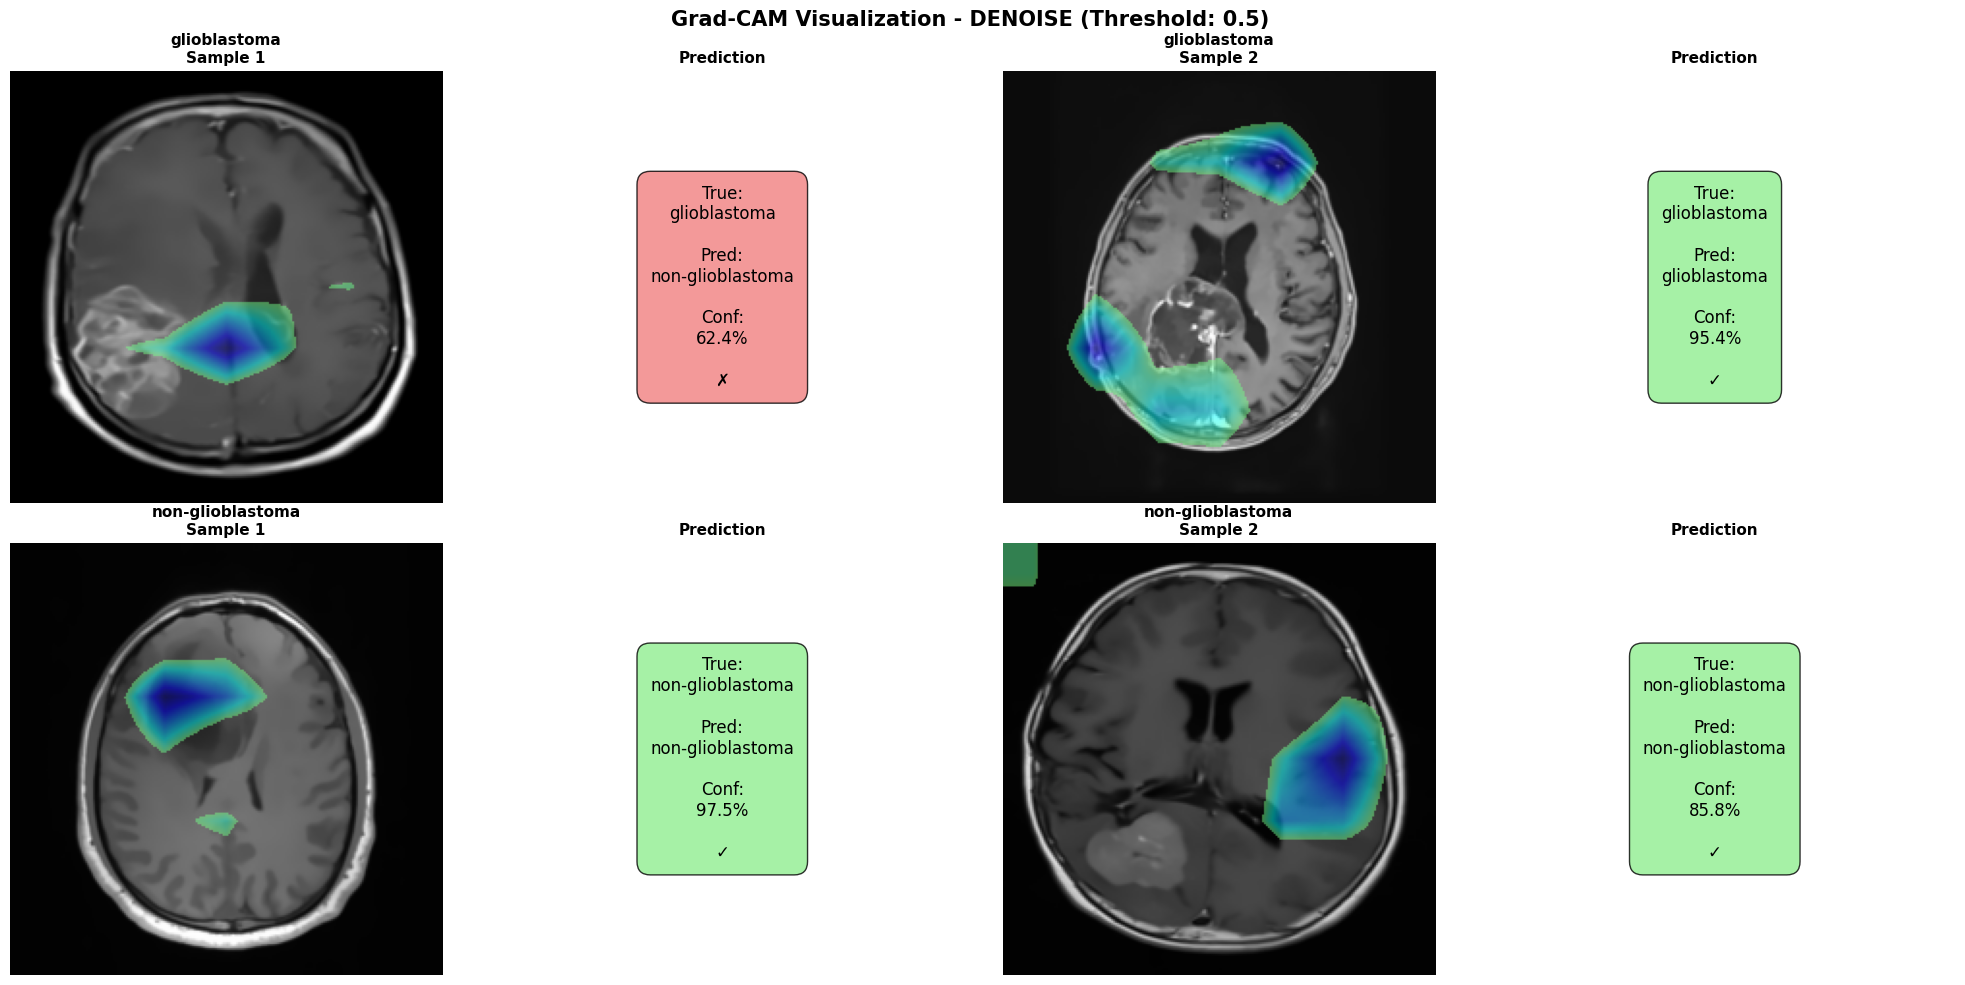

In [18]:
preprocess = "denoise"
train_generator, val_generator, test_generator = create_data_generators(df.copy(), preprocess)

print(f"\nBuild model")
model = build_model()

print(f"\nTraining model")
model, history, best_epoch = compile_and_train_model(
    model,
    train_generator,
    val_generator,
    epochs=config.EPOCHS
)

plot_training_history(history, best_epoch)

print("\nEvaluasi model")
metrics = evaluate_model(model, test_generator)

# Visualize Grad-CAM after training
print("\nGenerating Grad-CAM visualizations...")
visualize_gradcam_preprocessing(df[df['split'] == 'test'], model, preprocess, threshold=0.5)

model.save(f'{preprocess}.h5')


Found 617 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.

Build model

Training model
Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 299ms/step - accuracy: 0.6483 - loss: 0.6294 - precision: 0.6483 - recall: 0.6483 - val_accuracy: 0.7727 - val_loss: 0.5112 - val_precision: 0.7727 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.7634 - loss: 0.4771 - precision: 0.7634 - recall: 0.7634 - val_accuracy: 0.7803 - val_loss: 0.4562 - val_precision: 0.7803 - val_recall: 0.7803 - learning_rate: 1.0000e-04
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.7893 - loss: 0.4373 - precision: 0.7893 - recall: 0.7893 - val_accuracy: 0.7424 - val_loss: 0.4175 - val_precision: 0.7424 - val_recall: 0.7424 - learning_rate: 1.0000e-04
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.7958 - 

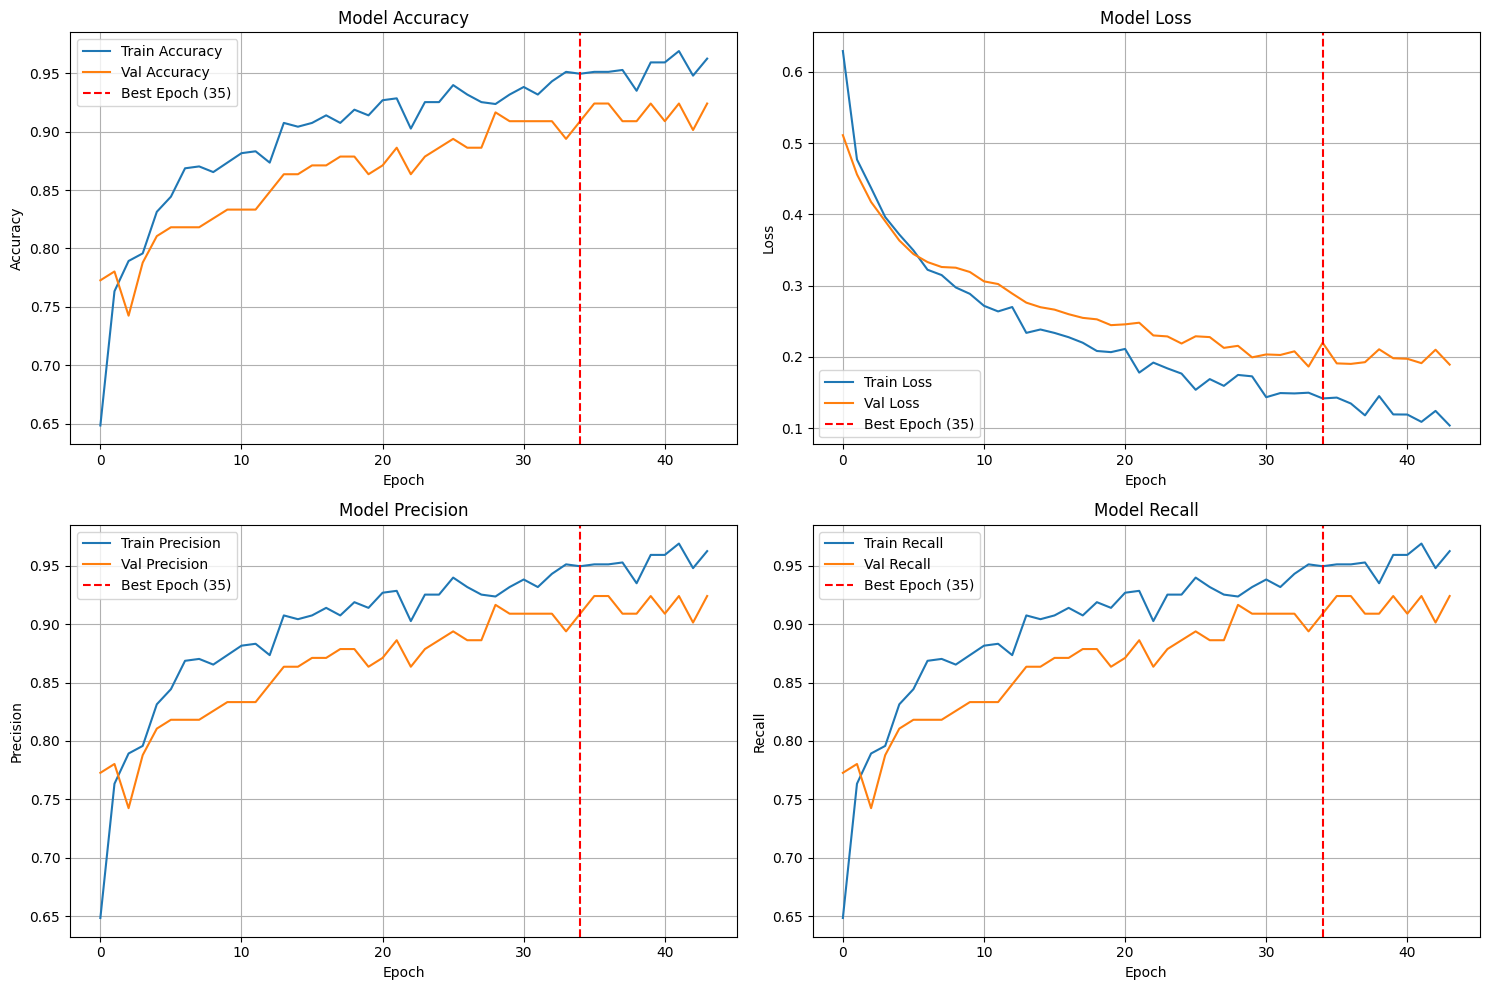


Evaluasi model
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step

Classification Report:
                  precision    recall  f1-score   support

    glioblastoma       0.90      0.84      0.87        31
non-glioblastoma       0.95      0.97      0.96       102

        accuracy                           0.94       133
       macro avg       0.92      0.90      0.91       133
    weighted avg       0.94      0.94      0.94       133



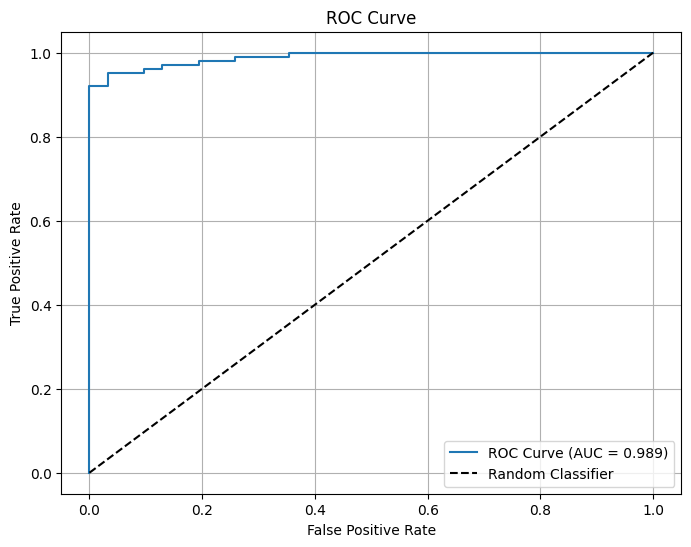


Hasil Evaluasi:
Accuracy: 0.9398
Precision: 0.9519
Recall: 0.9706
Specificity: 0.8387
F1-Score: 0.9612
AUC-ROC: 0.9889

Generating Grad-CAM visualizations...
Using layer 'top_activation' for Grad-CAM
Activation threshold: 0.5 (Red/Yellow = High importance)


/home/filkom/nada_tif/venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_994']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


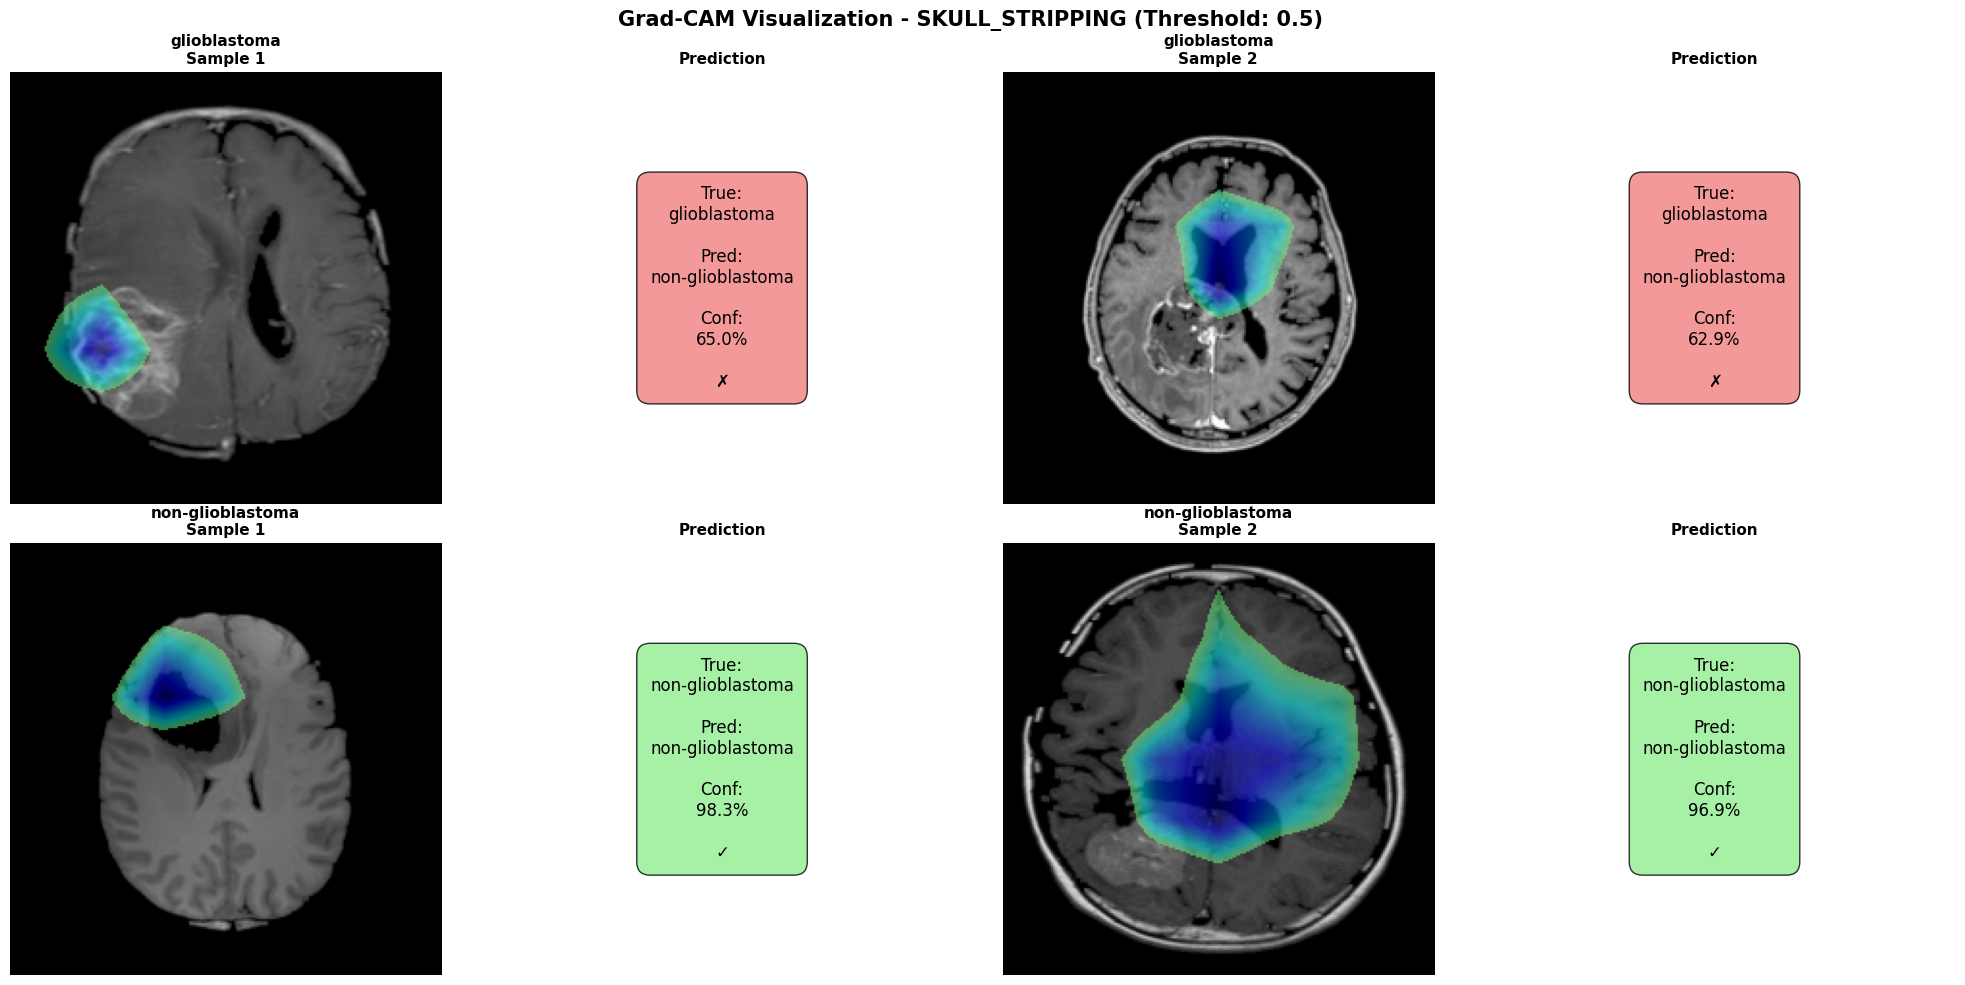

In [19]:
preprocess = "skull_stripping"
train_generator, val_generator, test_generator = create_data_generators(df.copy(), preprocess)

print(f"\nBuild model")
model = build_model()

print(f"\nTraining model")
model, history, best_epoch = compile_and_train_model(
    model,
    train_generator,
    val_generator,
    epochs=config.EPOCHS
)

plot_training_history(history, best_epoch)

print("\nEvaluasi model")
metrics = evaluate_model(model, test_generator)

# Visualize Grad-CAM after training
print("\nGenerating Grad-CAM visualizations...")
visualize_gradcam_preprocessing(df[df['split'] == 'test'], model, preprocess, threshold=0.5)

model.save(f'{preprocess}.h5')


Found 617 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.

Build model

Training model
Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.7293 - loss: 0.5285 - precision: 0.7293 - recall: 0.7293 - val_accuracy: 0.7727 - val_loss: 0.4438 - val_precision: 0.7727 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.7812 - loss: 0.4648 - precision: 0.7812 - recall: 0.7812 - val_accuracy: 0.7955 - val_loss: 0.3978 - val_precision: 0.7955 - val_recall: 0.7955 - learning_rate: 1.0000e-04
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.7828 - loss: 0.4095 - precision: 0.7828 - recall: 0.7828 - val_accuracy: 0.8333 - val_loss: 0.3795 - val_precision: 0.8333 - val_recall: 0.8333 - learning_rate: 1.0000e-04
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.8201 - 

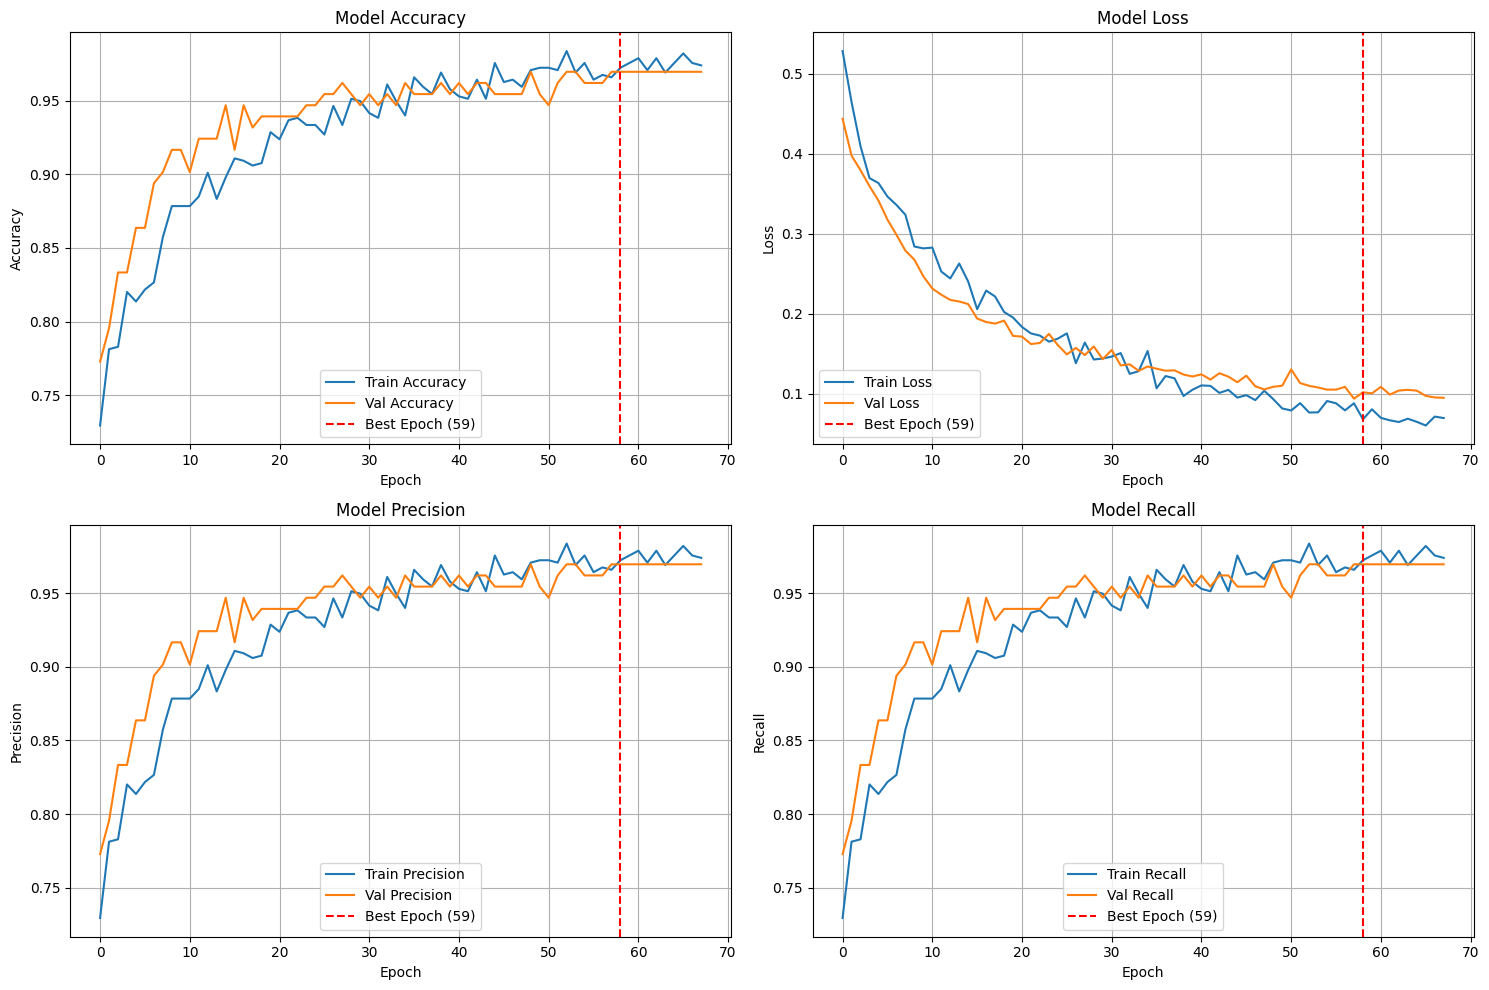


Evaluasi model
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step

Classification Report:
                  precision    recall  f1-score   support

    glioblastoma       0.91      0.97      0.94        31
non-glioblastoma       0.99      0.97      0.98       102

        accuracy                           0.97       133
       macro avg       0.95      0.97      0.96       133
    weighted avg       0.97      0.97      0.97       133



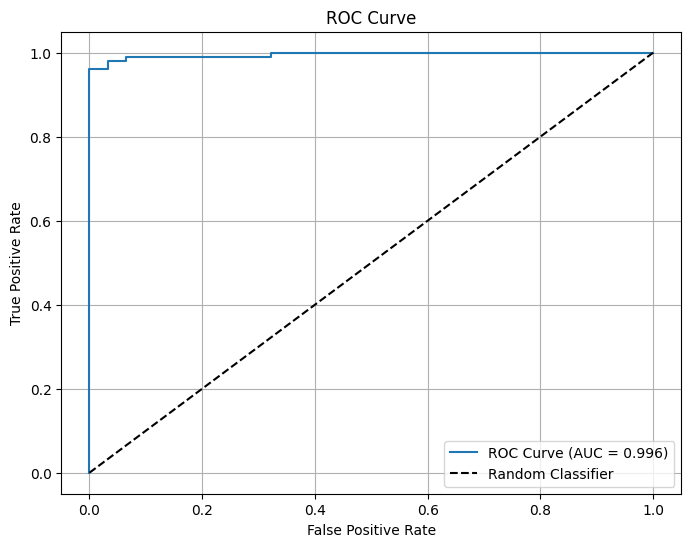


Hasil Evaluasi:
Accuracy: 0.9699
Precision: 0.9900
Recall: 0.9706
Specificity: 0.9677
F1-Score: 0.9802
AUC-ROC: 0.9956

Generating Grad-CAM visualizations...
Using layer 'top_activation' for Grad-CAM
Activation threshold: 0.5 (Red/Yellow = High importance)


/home/filkom/nada_tif/venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1494']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


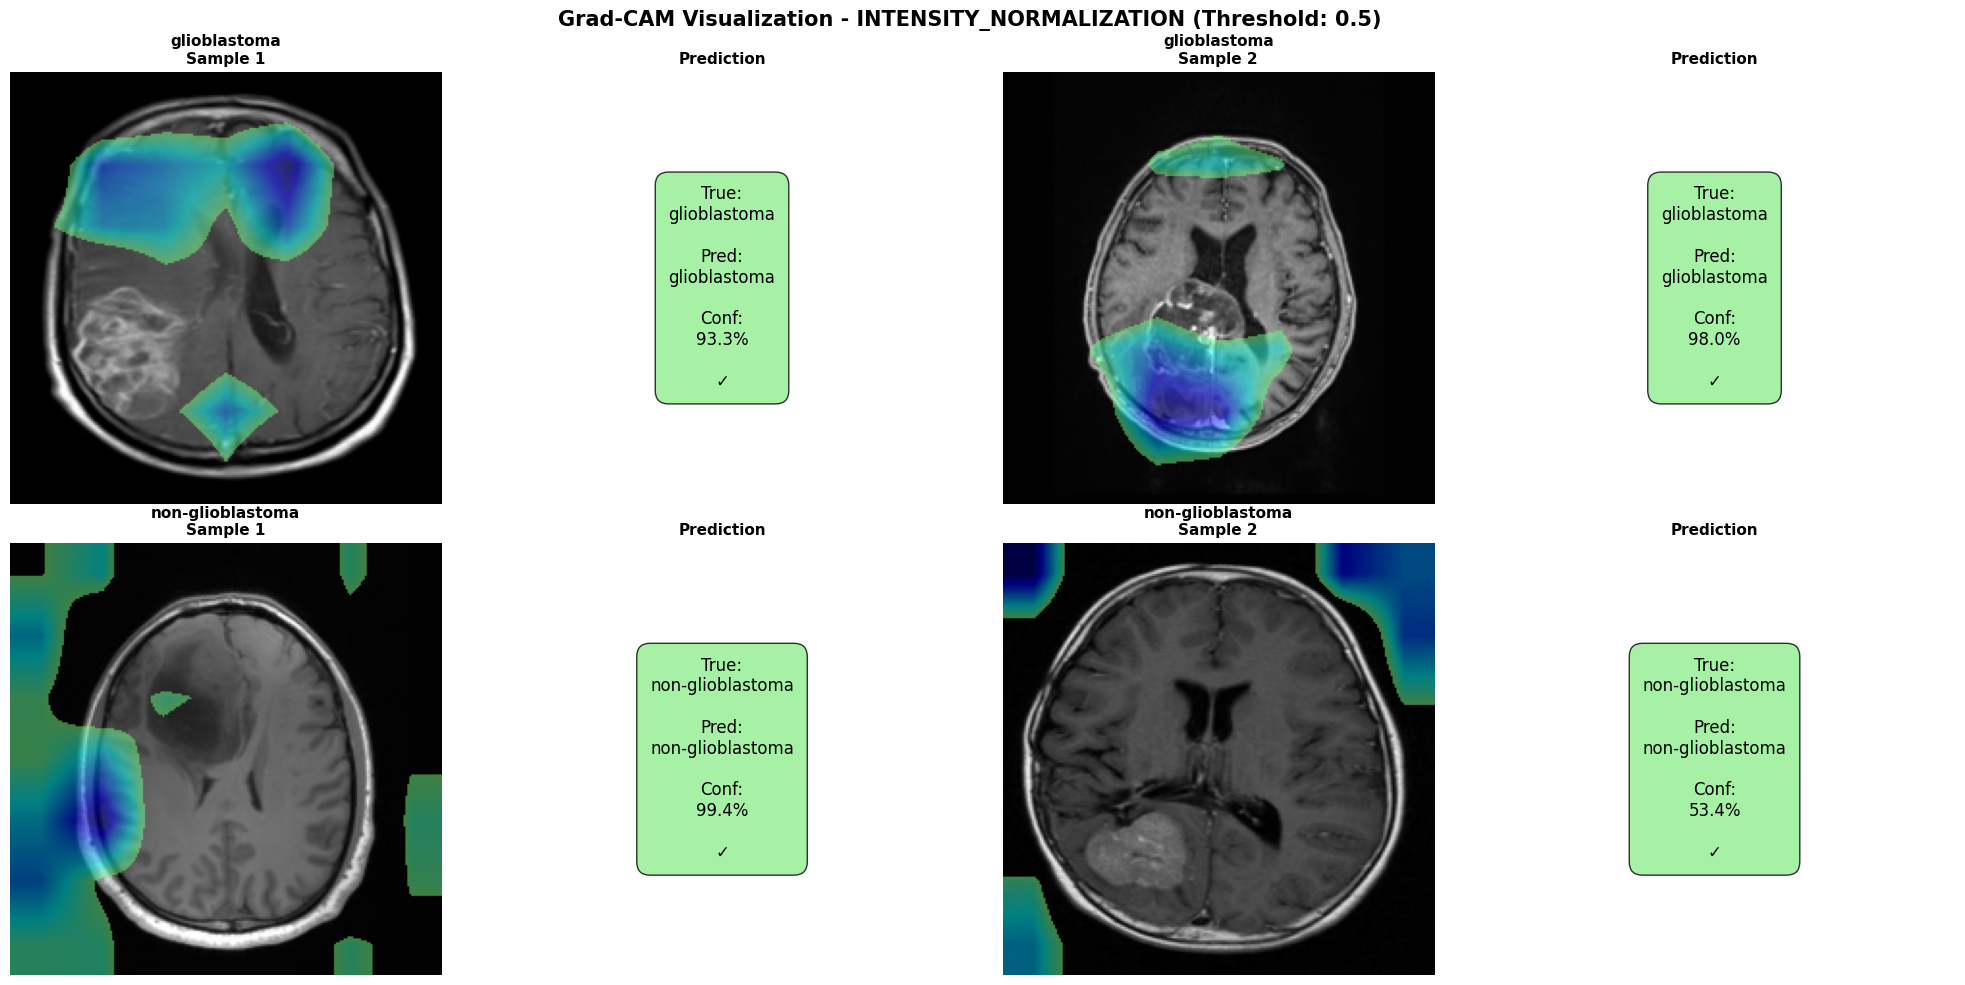

In [21]:
preprocess = "intensity_normalization"
train_generator, val_generator, test_generator = create_data_generators(df.copy(), preprocess)

print(f"\nBuild model")
model = build_model()

print(f"\nTraining model")
model, history, best_epoch = compile_and_train_model(
    model,
    train_generator,
    val_generator,
    epochs=config.EPOCHS
)

plot_training_history(history, best_epoch)

print("\nEvaluasi model")
metrics = evaluate_model(model, test_generator)

# Visualize Grad-CAM after training
print("\nGenerating Grad-CAM visualizations...")
visualize_gradcam_preprocessing(df[df['split'] == 'test'], model, preprocess, threshold=0.5)

model.save(f'{preprocess}.h5')
